In [1]:
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [2]:
N = 1000
p = 0.075  # 0.1

G = nx.erdos_renyi_graph(N, p, seed=1234)
nit = 500

model = ep.SEIRModel(G)

In [3]:
alpha = 0.05  # 0.01  # latent period (# iterations = 1/alpha: 5% = 20 it.)
beta = 0.0025  # infection rate
gamma = 0.1  # recovery rate
init = 5e-3  # initial infected population

print(model.parameters)
print(model.available_statuses)

config = mc.Configuration()
config.add_model_parameter('alpha', alpha)
config.add_model_parameter('beta',  beta)
config.add_model_parameter('gamma', gamma)
config.add_model_parameter("percentage_infected", init)

model.set_initial_status(config)

{'model': {'alpha': {'descr': 'Latent period (1/duration)', 'range': [0, 1], 'optional': False}, 'beta': {'descr': 'Infection rate', 'range': [0, 1], 'optional': False}, 'gamma': {'descr': 'Recovery rate', 'range': [0, 1], 'optional': False}, 'tp_rate': {'descr': 'Whether if the infection rate depends on the number of infected neighbors', 'range': [0, 1], 'optional': True, 'default': 1}}, 'nodes': {}, 'edges': {}}
{'Susceptible': 0, 'Exposed': 2, 'Infected': 1, 'Removed': 3}


In [4]:
iterations = model.iteration_bunch(nit, node_status=True)
trends = model.build_trends(iterations)

100%|██████████| 500/500 [00:08<00:00, 59.27it/s]


In [5]:
# G = jack.graph_tools(G)
# jack.graph_plots(G)
k = G.degree()
G.degree_list = [d for n, d in k]
G.k_avg = np.mean(G.degree_list)
print(G.k_avg)

75.028


In [6]:
S = np.array([S for S, E, I, R in
              [list(it['node_count'].values()) for it in iterations]])
# Ii = np.array([I for S, I, R in
#               [list(it['node_count'].values()) for it in iterations]])

Ii = np.array([E+I for S, E, I, R in
              [list(it['node_count'].values()) for it in iterations]])

''' Controllare la definizione di Ro nel modello SEIR, perche` il valore
effettivo sembra convergere meno alla previsione
'''

D = int(1/gamma)
Ro = beta * D * G.k_avg
Rt = Ro * S/N

# smoothing in funzione di D per togliere il rumore stocastico
Ir = pd.Series(list(Ii)).rolling(window=D).mean().iloc[D-1:].values

# a posteriori
K = np.diff(np.log(Ir/N))
R = np.exp(K * D)

print(Ro)

1.8757000000000001


In [7]:
print(np.log(Ir/N))

[-5.18498868 -5.18498868 -5.18498868 -5.20300719 -5.22135633 -5.27851474
 -5.33913936 -5.36019277 -5.40367788 -5.42615074 -5.44914026 -5.47267075
 -5.49676831 -5.49676831 -5.49676831 -5.49676831 -5.49676831 -5.52146092
 -5.52146092 -5.52146092 -5.49676831 -5.44914026 -5.40367788 -5.38169898
 -5.36019277 -5.33913936 -5.31852007 -5.31852007 -5.29831737 -5.27851474
 -5.25909665 -5.25909665 -5.27851474 -5.27851474 -5.27851474 -5.29831737
 -5.29831737 -5.27851474 -5.27851474 -5.27851474 -5.29831737 -5.31852007
 -5.31852007 -5.29831737 -5.27851474 -5.24004846 -5.22135633 -5.14989736
 -5.08320599 -5.02068563 -4.94766049 -4.86653495 -4.81589122 -4.77952357
 -4.74443225 -4.69948087 -4.63562939 -4.60517019 -4.56594947 -4.51899249
 -4.48295255 -4.45675018 -4.43121688 -4.40631933 -4.37405847 -4.35052797
 -4.33514305 -4.31999124 -4.31999124 -4.31999124 -4.31250057 -4.31250057
 -4.30506559 -4.29768549 -4.29768549 -4.29768549 -4.29768549 -4.29035945
 -4.26869795 -4.25451331 -4.24749574 -4.21990779 -4

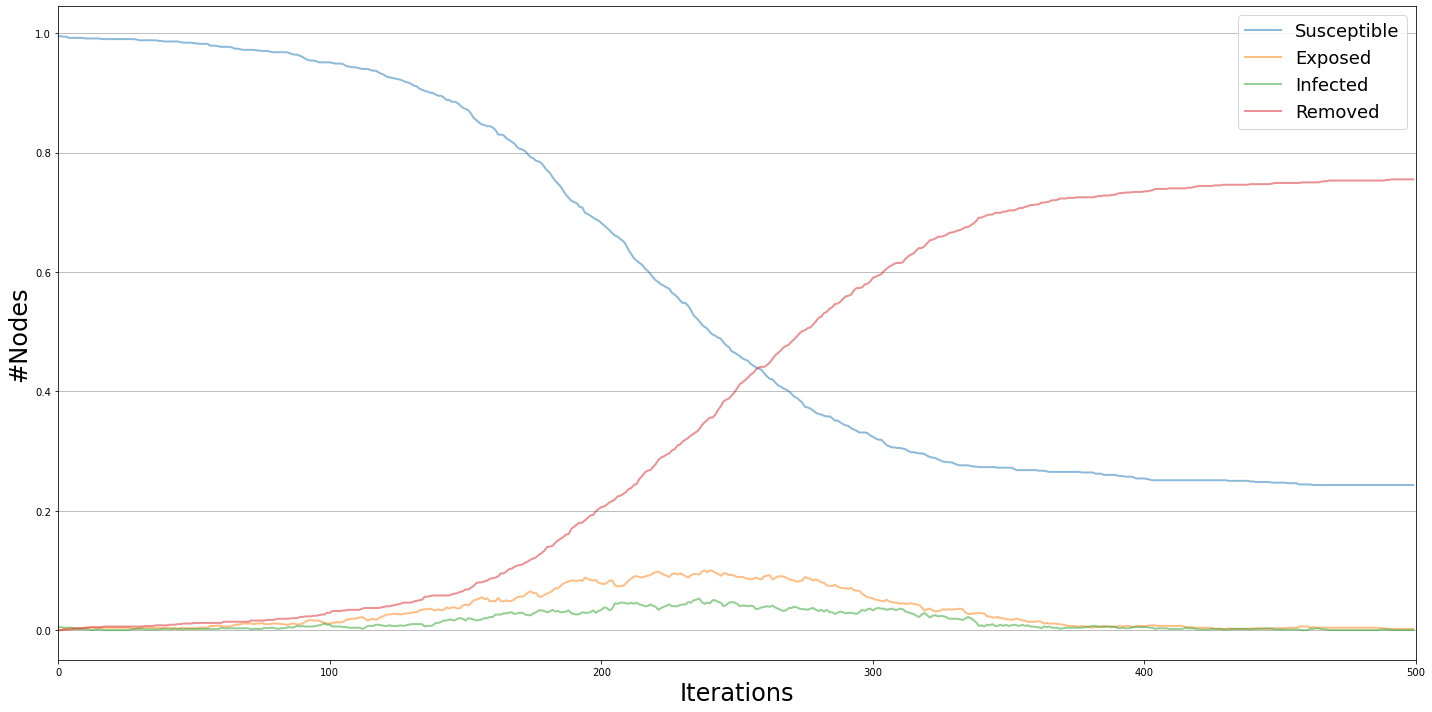

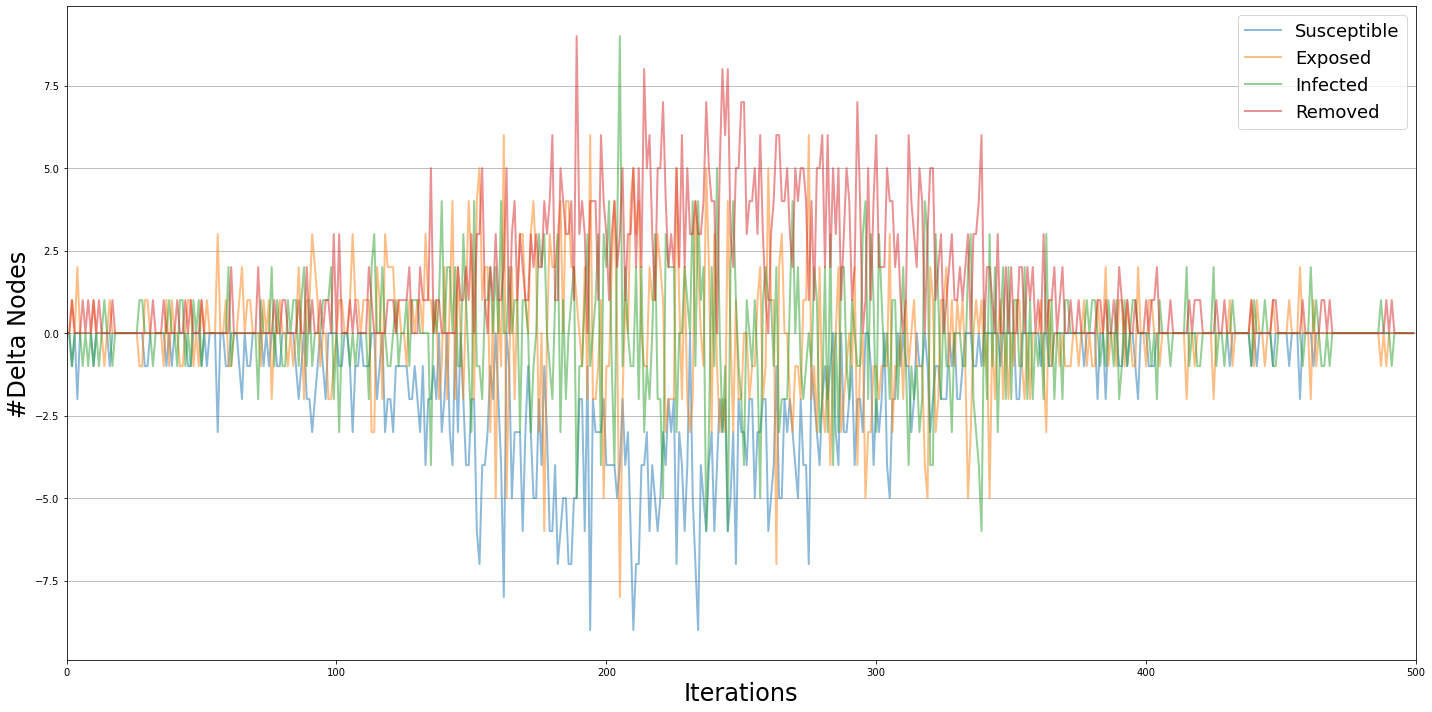

In [8]:
viz = DiffusionTrend(model, trends)
viz.plot()


viz = DiffusionPrevalence(model, trends)
viz.plot()

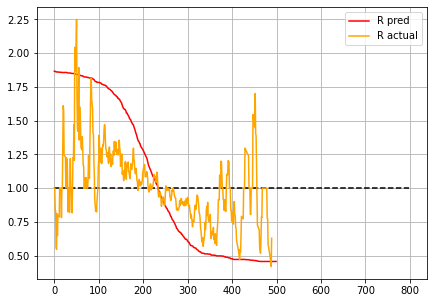

In [9]:
figR = plt.figure(figsize=(7, 5))
plt.plot([1 for i in range(800)], 'k--')
plt.plot(Rt, 'r', label='R pred')
plt.plot(R, 'orange', label='R actual')
plt.legend(loc='best')
plt.grid()